load a dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
hits_train = pd.read_csv("train.csv")

In [5]:
hits_train.head()

,global_id,event_id,wire_id,energy_deposit,relative_time,label
0,0,0,0,0.000000e+00,0.000000,0
1,1,0,1,0.000000e+00,0.000000,0
2,2,0,2,0.000000e+00,0.000000,0
3,3,0,3,0.000000e+00,0.000000,0
4,4,0,4,1.178108e-08,22.224176,2


In [6]:
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]
X = candidates[['energy_deposit','relative_time']].values
y = (candidates.label == 1).values

In [7]:
X.shape,y.shape

((1173167, 2), (1173167,))

In [8]:
y

array([False,  True, False, ..., False, False, False], dtype=bool)

train test split example

In [9]:
from sklearn.cross_validation import train_test_split

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
train_data.shape, test_data.shape

((821216, 2), (351951, 2))

Visualize the data

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
train_labels

array([False, False, False, ..., False, False, False], dtype=bool)

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


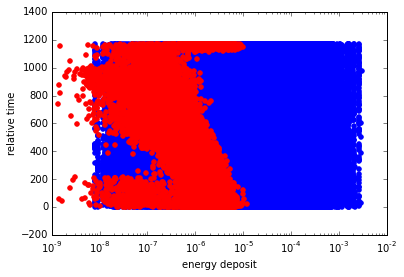

In [14]:
sig = np.where(train_labels==1)
bkg = np.where(train_labels==0)
plt.scatter(train_data[bkg,0], train_data[bkg,1], color='b')
plt.scatter(train_data[sig,0], train_data[sig,1], color='r')
plt.xscale('log')
plt.xlim(1e-9,1e-2)
plt.ylabel('relative time')
plt.xlabel('energy deposit')
plt.show()

example of decistion tree

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score
acc = accuracy_score( test_labels, rf.predict(test_data))
print acc*100,"% accuracy"

89.0797298488 % accuracy


PCA example for data transformation

In [17]:
from sklearn.decomposition import PCA

In [18]:
base = PCA(n_components=2)
base.fit(train_data)

PCA(copy=True, n_components=2, whiten=False)

In [19]:
new_data = base.transform(train_data)

In [20]:
new_data.shape

(821216, 2)

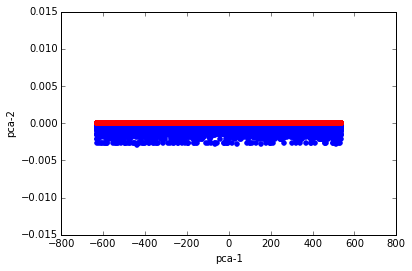

In [21]:
plt.scatter(new_data[bkg,0], new_data[bkg,1], color='b')
plt.scatter(new_data[sig,0], new_data[sig,1], color='r')
#plt.xscale('log')
#plt.xlim(1e-9,1e-2)
plt.ylabel('pca-2')
plt.xlabel('pca-1')
plt.show()

In [22]:
rf_2 = RandomForestClassifier()
rf_2.fit(new_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
new_test = base.transform(test_data)

In [24]:
acc_2 = accuracy_score( test_labels, rf_2.predict(new_test))
print acc_2*100,"% accuracy"

89.0979141983 % accuracy


we can do both in a pipeline

In [25]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[('pca', base) , ('rf',RandomForestClassifier())])

pipe.fit( train_data, train_labels )

Pipeline(steps=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [26]:
acc_3 = accuracy_score( test_labels, rf_2.predict(test_data))
print acc_3*100,"% accuracy"

89.0748996309 % accuracy


example of cross validation

In [42]:
from sklearn.cross_validation import cross_val_score, KFold
scores = cross_val_score(pipe, train_data, train_labels, 
                         cv=KFold(train_data.shape[0],n_folds=20, random_state=42), 
                         scoring="accuracy")

In [43]:
print scores.mean(),scores.std()

0.890720584766 0.0013381932423


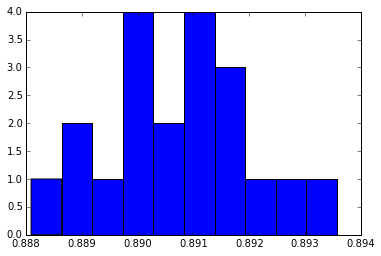

In [44]:
plt.hist( scores )
plt.show()

example of grid search

have we used the best parameters for all

In [45]:
from sklearn.grid_search import GridSearchCV

In [49]:
grid = GridSearchCV(pipe,
                    param_grid={"pca__n_components": [1,2],
                                "rf__n_estimators": [5,10,20],
                                "rf__max_features": [0.1, 0.25, 0.5]
                                },
                    cv=KFold(train_data.shape[0],n_folds=20, random_state=42),
                    scoring='accuracy',
                    n_jobs=5,
                    verbose=1)

In [50]:
grid.fit(train_data, train_labels)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=821216, n_folds=20, shuffle=False, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'pca__n_components': [1, 2], 'rf__max_features': [0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [51]:
print grid.best_params_

{'pca__n_components': 2, 'rf__max_features': 0.1}


Kmeans example with cluster # search ?

much more at http://scikit-learn.org 